# NHS Winter SitRep

Notebook starting to explore NHS Winter Sitrep Data.

*The original version of this notebook with working notes on the creation of the data harvester can be found here:  [../archive/Winter_SitRep_old.ipynb](../archive/Winter_SitRep_old.ipynb).*

The [NHS Winter Sitrep data from 2017-18](https://www.england.nhs.uk/statistics/statistical-work-areas/winter-daily-sitreps/winter-daily-sitrep-2017-18-data/) is available as daily data published on a weekly basis in the form of an Excel spreadsheet. A time series spreadsheet is also published weekly that collates data from all the weekly spreadsheets in the 2017-18 Winter collection period.

The [psychemedia/openHealthDataDoodles/tree/cli_winter_sitrep](https://github.com/psychemedia/openHealthDataDoodles/tree/cli_winter_sitrep) utility is a command line tool that attempts to download the most recent timeseries spreadsheets for *Acute* and *NHS111* sitreps, and extract the data into a simple unnormalised SQLite3 database tables, one for the *Acute* data, one for the *NHS111* data.

*If you are running this notebook from the orginal repository via Binderhub, the `cli_winter_sitrep` utility should already be installed.*

In [8]:
# Attempt to collect the most recent data
!nhs_winter_sitrep collect

Grabbing data for Winter Sitrep: Acute Time series 20 November 2017 to 31 December 2017 (XLSX, 774kB)
Grabbing data for Winter SitRep: NHS111 Time series 20 November 2017 to 31 December 2017 (XLSX, 395kB)
/srv/venv/lib/python3.5/site-packages/pandas/core/generic.py:1534: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


In [235]:
%matplotlib inline
import pandas as pd
import natural_time_periods as ntpd
from dateutil import parser

### Accessing the database

In [9]:
import sqlite3
conn = sqlite3.connect('nhs_sitrepdb.sqlite3')

In [10]:
q="SELECT name FROM sqlite_master WHERE type='table';"

pd.read_sql_query(q,conn)

,name
0,sitrep
1,nhs111


In [11]:
#Test query - sitrep
pd.read_sql_query("SELECT * FROM sitrep LIMIT 5;", conn, parse_dates=['Date'])

,Date,Area,Code,Name,value,Category,Report
0,2017-11-20,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures
1,2017-11-21,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures
2,2017-11-22,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures
3,2017-11-23,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures
4,2017-11-24,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures


In [39]:
pd.read_sql_query("SELECT DISTINCT Report, Category FROM sitrep;", conn)

,Report,Category
0,A&E closures,A&E closures
1,A&E diverts,A&E diverts
2,G&A beds,Core Beds Open
3,G&A beds,Escalation Beds Open
4,G&A beds,Total Beds Open
5,G&A beds,Total beds occ'd
6,G&A beds,Occupancy rate
7,Beds Occ by long stay patients,> 7 days
8,Beds Occ by long stay patients,> 21 days
9,"D&V, Norovirus",Beds closed


In [12]:
#Test query - nhs111
pd.read_sql_query("SELECT * FROM nhs111 LIMIT 5;", conn, parse_dates=['Date'])

,Category,Date,Region,Code,NHS 111 area name,Report,value
0,Calls answered within 60 Seconds,2017-11-20,North,111AA1,North East England NHS 111,Answered in 60,2400.0
1,Calls answered within 60 Seconds,2017-11-21,North,111AA1,North East England NHS 111,Answered in 60,2135.0
2,Calls answered within 60 Seconds,2017-11-22,North,111AA1,North East England NHS 111,Answered in 60,2163.0
3,Calls answered within 60 Seconds,2017-11-23,North,111AA1,North East England NHS 111,Answered in 60,1899.0
4,Calls answered within 60 Seconds,2017-11-24,North,111AA1,North East England NHS 111,Answered in 60,1957.0


In [38]:
pd.read_sql_query("SELECT DISTINCT Report, Category FROM nhs111;", conn)

,Report,Category
0,Answered in 60,Calls answered within 60 Seconds
1,Answered in 60,Calls answered
2,Abandoned,Calls abandoned after at least 30 seconds waiting
3,Abandoned,Calls offered
4,Triage,Calls where person triaged
5,Clinical Advisor,Calls transferred to or answered by a clinical...
6,Clinical Input,Calls to a CAS clinician
7,Call Back,Calls back within 10 minutes
8,Call Back,Calls where person offered call back
9,Dispositions,Ambulance dispatches


## Utils

Helpful quueries wrapped in functions.

In [ ]:
def lookupTrust(conn,trust, typ='sitrep'):
    typ = typ.lower()
    name='NHS 111 area name' if typ=='nhs111' else 'Name'
    area='Region' if typ=='nhs111' else 'Area'
    q='''SELECT DISTINCT "{name}",{area}, code FROM {typ} WHERE LOWER("{name}") LIKE "%{trust}%";'''.format(typ=typ,
                                                                                                            name=name, 
                                                                                                            trust=trust.lower(),
                                                                                                            area=area)
    return pd.read_sql_query(q, conn)


def lookupTrustCode(conn,trust, typ='sitrep'):
    df=lookupTrust(conn,trust, typ=typ)
    name='NHS 111 area name' if typ.lower()=='nhs111' else 'Name'
    if len(df) > 1: return df
    return df[name].iloc[0],df['Code'].iloc[0]

In [144]:
lookupTrust(conn,'Wight')

,Name,Area,Code
0,Isle Of Wight NHS Trust,South Of England Commissioning Region,R1F


In [145]:
lookupTrust(conn,'Wight', 'NHS111')

,NHS 111 area name,Region,Code
0,Isle Of Wight NHS 111,South,111AA6


In [147]:
lookupTrustCode(conn,'Wight', 'NHS111')

('Isle Of Wight NHS 111', '111AA6')

In [148]:
lookupTrustCode(conn,'Wight', 'sitrep')

('Isle Of Wight NHS Trust', 'R1F')

In [151]:
lookupTrustCode(conn,'London', 'NHS111')

,NHS 111 area name,Region,Code
0,Inner North West London NHS 111,London,111AA7
1,Hillingdon London NHS 111,London,111AA9
2,South West London NHS 111,London,111AG5
3,North West London NHS 111,London,111AD4
4,North Central London NHS 111,London,111AD5
5,Outer North East London NHS 111,London,111AD6
6,South East London NHS 111,London,111AD7
7,East London & City NHS 111,London,111AD8
8,LONDON REGION,London,None


In [157]:
def lookupFromTrustCode(conn,code, typ='sitrep'):
    typ = typ.lower()
    name='NHS 111 area name' if typ=='nhs111' else 'Name'
    area='Region' if typ=='nhs111' else 'Area'
    q='''SELECT DISTINCT "{name}",{area}, code FROM {typ} WHERE LOWER(Code) LIKE "%{code}%";'''.format(typ=typ,
                                                                                                            name=name, 
                                                                                                            code=code.lower(),
                                                                                                            area=area)
    return pd.read_sql_query(q, conn).iloc[0].to_dict()

In [158]:
lookupFromTrustCode(conn,'R1F')

{'Area': 'South Of England Commissioning Region',
 'Code': 'R1F',
 'Name': 'Isle Of Wight NHS Trust'}

#### `inflect`
The [`inflect` package](https://github.com/pwdyson/inflect.py) provides a variety of functions for generating text.

In [46]:
import inflect
p = inflect.engine()

### Test plot

In [21]:
def timeSeriesPlot(df,time='Date',val='value',title=''):
    df.set_index('Date')['value'].plot(title=title)

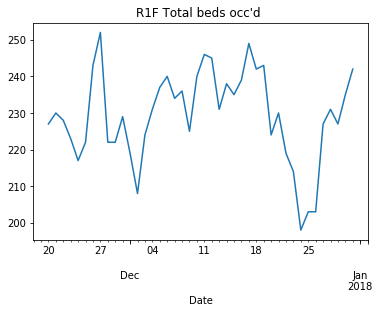

In [23]:
q='''
SELECT * FROM sitrep WHERE Category = "Total beds occ'd" AND Code="R1F";
'''

df = pd.read_sql_query(q, conn, parse_dates=['Date'])

timeSeriesPlot(df,title="R1F Total beds occ'd ")

### Time limited queries

In [228]:
def getperiod_dates(nl_period):
    if nl_period is None: return ''
    period = ''.join(nl_period.lower().split()) if nl_period is not None else nl_period
    if period in ['lastmonth', 'lastweek']:    
        if period == 'lastmonth': fromdate,todate=(ntpd.last_month(iso=True))
        elif period == 'lastweek': fromdate,todate=(ntpd.last_week(iso=True))
        return fromdate, todate
    return ''

def getperiod_sql_clause(nl_period, col='Date'):
    period = getperiod_dates(nl_period)
    if not period: return period
    else: (fromdate, todate)=period
    q=' AND date({col}) BETWEEN date("{fromdate}") AND date("{todate}") '.format(col=col, fromdate=fromdate,
                                                                                      todate=todate)
    return q       

In [230]:
getperiod_dates('last week'), getperiod_sql_clause('last month')

(('2017-12-25', '2017-12-31'),
 ' AND date(Date) BETWEEN date("2017-12-01") AND date("2017-12-31") ')

In [ ]:
def period_text(period):
    p  = getperiod_dates(period)
    if p: return '({} to {})'.format(parser.parse(p[0]).strftime('%A %d %B %Y'),
                                     parser.parse(p[1]).strftime('%A %d %B %Y'))
    return ''

In [243]:
period_text('last week')

'(Monday 25 December 2017 to Sunday 31 December 2017)'

In [218]:
def timeSeriesSelectPlot(code, category, report=None, title=None, period=None):
    q=''' SELECT * FROM sitrep WHERE Category = "{category}" AND Code="{code}"'''.format(category=category,code=code)
    #We may have to disambiguate category values
    if report is not None:
        q=q+' AND Report="{report}"'.format(report=report)
    
    #Add time limit
    q = q+ getperiod_sql_clause(period, col='Date')
    
    df = pd.read_sql_query(q, conn, parse_dates=['Date'])
    if title is None:
        title = '{} - '.format(report) if report is not None else ''
        title = '{}{} for {}'.format(title, category,code)
            
    timeSeriesPlot(df,title=title)

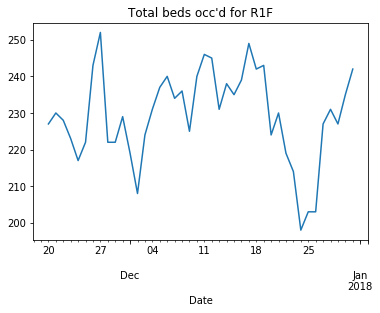

In [219]:
timeSeriesSelectPlot('R1F',"Total beds occ'd")

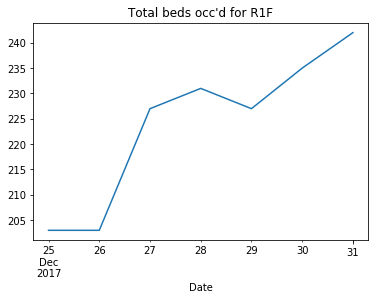

In [163]:
timeSeriesSelectPlot('R1F',"Total beds occ'd", period='last week')

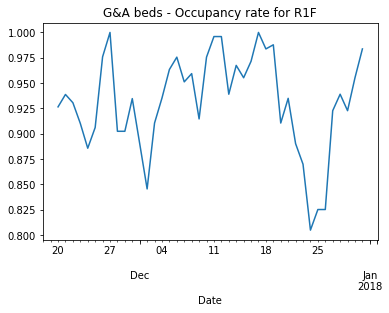

In [44]:
timeSeriesSelectPlot('R1F',"Occupancy rate",report="G&A beds")

## Using the data to verify previously published reports

For example, via @carlbaker, I see this:

![](https://pbs.twimg.com/media/DSr_wHqW0AMxwzE.png)

Let's get a count of the delayed ambulances, by Trust, within that period:

In [40]:
q='''
SELECT  Name, SUM(value) FROM sitrep 
WHERE date(Date) BETWEEN date('2017-12-25') AND date('2017-12-31') 
AND (Category = 'Delay >60 mins' OR Category='Delay 30-60 mins') AND value NOT NULL GROUP BY Name ORDER BY SUM(value) DESC
;
'''

pd.read_sql_query(q, conn).head()

,Name,SUM(value)
0,East Kent Hospitals University NHS Foundation ...,585
1,Worcestershire Acute Hospitals NHS Trust,413
2,East Lancashire Hospitals NHS Trust,391
3,Lancashire Teaching Hospitals NHS Foundation T...,390
4,United Lincolnshire Hospitals NHS Trust,373


We can also find the total number of arrivals for each Trust in the same period:

In [41]:
q2='''
SELECT  Name, SUM(value) FROM sitrep 
WHERE date(Date) BETWEEN date('2017-12-25') AND date('2017-12-31') 
AND Category = 'Arriving by ambulance'  AND value NOT NULL GROUP BY Name ORDER BY SUM(value) DESC
;
'''

pd.read_sql_query(q2, conn).head()


,Name,SUM(value)
0,Barts Health NHS Trust,1783
1,Pennine Acute Hospitals NHS Trust,1699
2,Heart Of England NHS Foundation Trust,1535
3,Leeds Teaching Hospitals NHS Trust,1429
4,Frimley Health NHS Foundation Trust,1402


Now we can combine those and find the percentage of total arrivials to each Trust that were delayed, ordering from most delayed.

In [42]:
q3='''
SELECT total.Name, Delayed, Total, 100.0*Delayed/Total AS pc FROM (SELECT  Name, SUM(value) AS Delayed FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND (Category = 'Delay >60 mins' OR Category='Delay 30-60 mins') 
AND value NOT NULL GROUP BY Name) delayed JOIN (SELECT  Name, SUM(value) AS Total FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category = 'Arriving by ambulance' AND value NOT NULL GROUP BY Name) total on total.Name = delayed.Name 
ORDER BY pc DESC
'''.format(fromdate='2017-12-25', todate='2017-12-31')
tmp = pd.read_sql_query(q3, conn)
tmp.head(10)

,Name,Delayed,Total,pc
0,"The Queen Elizabeth Hospital, King's Lynn, NHS...",239,418,57.177033
1,Lancashire Teaching Hospitals NHS Foundation T...,390,724,53.867403
2,East Lancashire Hospitals NHS Trust,391,890,43.932584
3,East Kent Hospitals University NHS Foundation ...,585,1350,43.333333
4,Sherwood Forest Hospitals NHS Foundation Trust,274,637,43.014129
5,Portsmouth Hospitals NHS Trust,321,753,42.629482
6,Mid Essex Hospital Services NHS Trust,243,592,41.047297
7,Kettering General Hospital NHS Foundation Trust,240,618,38.834951
8,Worcestershire Acute Hospitals NHS Trust,413,1103,37.443336
9,The Dudley Group NHS Foundation Trust,344,951,36.172450


Let's compare:

![](https://pbs.twimg.com/media/DSr_wHqW0AMxwzE.png)

That display may not be so useful though, because the population sizes differ. Something along the lines of a [funnel plot](https://blog.ouseful.info/2011/10/31/power-tools-for-aspiring-data-journalists-r/) can be used to check rates where rate distrbutions are statistically normal, which may not be the case here. 

For now let's stick with a scatter plot withouth any distribution guide lines to see if there are any outliers:

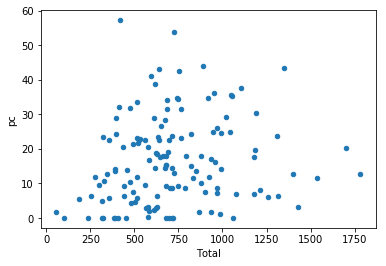

In [43]:
pd.read_sql_query(q3, conn).plot(kind='scatter', x='Total',y='pc');

If we're looking for stories, outliers are a good place to start. For example trusts where there is a high rate of delays (*y-axis in chart above*), or perhaps a large number of delays.

Let's size the scatter plot by the number of delayed visits to see if any points jump out.

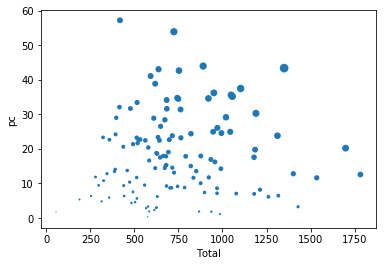

In [44]:
pd.read_sql_query(q3, conn).plot(kind='scatter', x='Total',y='pc', s=tmp['Delayed']/10);

We can also look for trusts whre there is a large number of delays more directly. In this case, a high *y-axis* value is bad...:

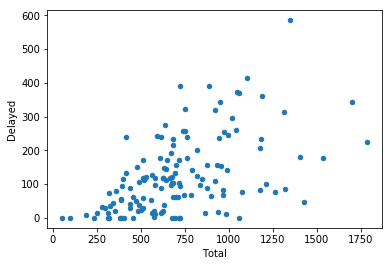

In [45]:
pd.read_sql_query(q3, conn).plot(kind='scatter', x='Total',y='Delayed');

Again, we can add a bit more subtlety to the chart by sizing the nodes, in this case, by the delay rate:

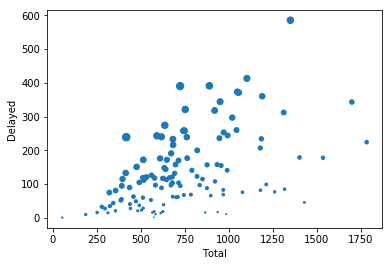

In [46]:
#Size by percent...
tmp=pd.read_sql_query(q3, conn)
tmp.plot(kind='scatter', x='Total',y='Delayed', s=tmp['pc']);

Let's have a go at adding some sort of distribution guide. Anything above the line is what we're looking for...:

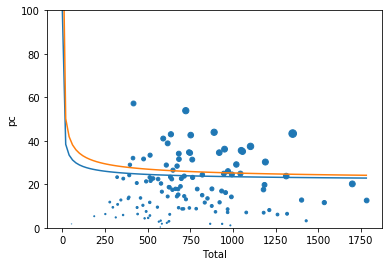

In [47]:
import matplotlib.pyplot as plt

tmp.plot(kind='scatter', x='Total',y='pc', s=tmp['Delayed']/10, ylim=(0,100));

#Not sure if I'm doing this right? Normal distribution model is wrong for a start?
import numpy as np
import weightedstats as ws

tmp=tmp
number=tmp['Total']
p=tmp['pc']/100

p_se = np.sqrt( (p*(1-p)) / (number) )

p_fem = ws.weighted_mean(p, weights=p_se)
dff = pd.DataFrame({'Total':np.arange(1, max(tmp['Total']), 20)})
dff['number_ul95'] = 100 * ( p_fem + 1.96 * np.sqrt((p_fem*(1-p_fem)) / dff['Total']) )
dff['number_ul999'] = 100 * ( p_fem + 3.29 * np.sqrt((p_fem*(1-p_fem)) / dff['Total']) )
plt.plot(dff['Total'],dff['number_ul95'] )
plt.plot(dff['Total'],dff['number_ul999'] );


Here's another table we could try to recreate, again via @carlbaker: *Bed Occupancy*:

![](https://pbs.twimg.com/media/DSsDvgMW4AATHKK.png)

But how do we calculate this? The average of the occupancy rates over the week?

Which data sheet(s) does the data come from and how is it analysed to generate that table?

For example, what if we naively just try to take the average of the rates for each trust over the week?

In [48]:
q4='''
SELECT Name, 100*AVG(value) AS av FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category = "Occupancy rate" GROUP BY Name
ORDER BY av DESC
'''.format(fromdate='2017-12-25', todate='2017-12-31')
pd.read_sql_query(q4, conn).head(10)

,Name,av
0,Weston Area Health NHS Trust,96.274174
1,James Paget University Hospitals NHS Foundatio...,96.191210
2,Harrogate And District NHS Foundation Trust,95.764972
3,University Hospitals Birmingham NHS Foundation...,95.652122
4,St Helens And Knowsley Hospital Services NHS T...,95.351082
5,King's College Hospital NHS Foundation Trust,94.762360
6,North Middlesex University Hospital NHS Trust,94.109607
7,Nottingham University Hospitals NHS Trust,93.903388
8,Countess Of Chester Hospital NHS Foundation Trust,93.614342
9,North Cumbria University Hospitals NHS Trust,93.088257


This is why I think research reports need to show their working or at least have the working available...

## Isle of Wight Report

General reports for Isle of Wight.

In [49]:
code='R1F'

df= pd.DataFrame()
for reportname in reports:
    report = get_report(xl,reportname)
    report['ReportCategory']=report['Report']+'_'+report['Category']
    #for reportItem in reportItems(report):
    df = pd.concat([df,report[(report['Code']==code)][['Date','ReportCategory','value']]])
df.tail()

,Date,ReportCategory,value
14359,2017-12-30,Ambulance Arrivals and Delays_Delay 30-60 mins,3.0
14360,2017-12-30,Ambulance Arrivals and Delays_Delay >60 mins,1.0
14361,2017-12-31,Ambulance Arrivals and Delays_Arriving by ambu...,52.0
14362,2017-12-31,Ambulance Arrivals and Delays_Delay 30-60 mins,2.0
14363,2017-12-31,Ambulance Arrivals and Delays_Delay >60 mins,1.0


Make a wide version of the data

In [50]:
dfw = df.pivot( index='Date',columns='ReportCategory', values='value')
dfw.head()

ReportCategory,A&E closures_A&E closures,A&E diverts_A&E diverts,Adult critical care_CC Adult Occ,Adult critical care_CC Adult Open,Adult critical care_CC Adult avail,Adult critical care_Occupancy rate,Ambulance Arrivals and Delays_Arriving by ambulance,Ambulance Arrivals and Delays_Delay 30-60 mins,Ambulance Arrivals and Delays_Delay >60 mins,Beds Occ by long stay patients_> 21 days,...,G&A beds_Total Beds Open,G&A beds_Total beds occ'd,Neonatal intensive care _Neo Int Care Avail,Neonatal intensive care _Neo Int Care Occ,Neonatal intensive care _Neo Int Care Open,Neonatal intensive care _Occupancy rate,Paediatric intensive care_Occupancy rate,Paediatric intensive care_Paed Int Care Avail,Paediatric intensive care_Paed Int Care Occ,Paediatric intensive care_Paed Int Care Open
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-20,0.0,0.0,4.0,NaN,6.0,0.666667,49.0,4.0,0.0,50.0,...,245.0,227.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2017-11-21,0.0,0.0,4.0,NaN,6.0,0.666667,52.0,1.0,1.0,50.0,...,245.0,230.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2017-11-22,0.0,0.0,6.0,NaN,6.0,1.000000,45.0,0.0,1.0,48.0,...,245.0,228.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2017-11-23,0.0,0.0,4.0,NaN,6.0,0.666667,52.0,0.0,1.0,46.0,...,245.0,223.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2017-11-24,0.0,0.0,3.0,NaN,6.0,0.500000,46.0,1.0,3.0,54.0,...,245.0,217.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


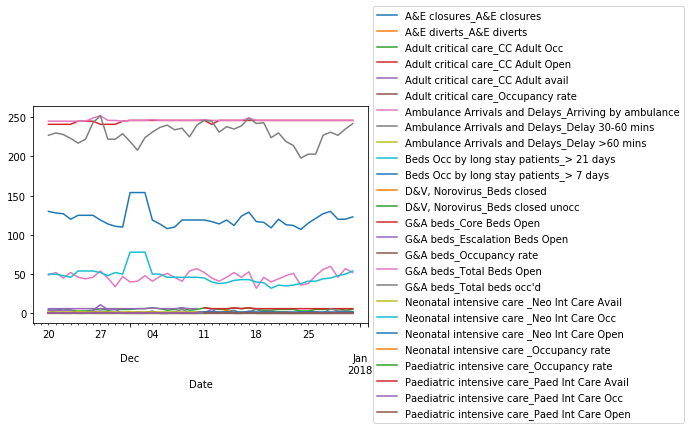

In [51]:
dfw.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5));

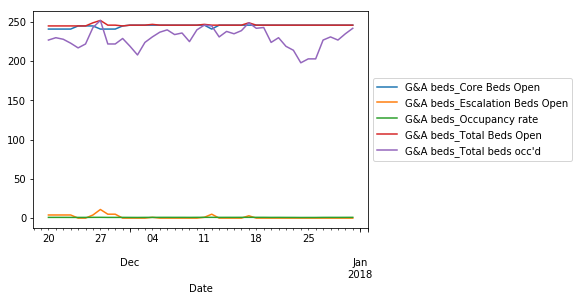

In [52]:
cols=[c for c in dfw.columns if 'G&A' in c]
dfw[cols].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5));

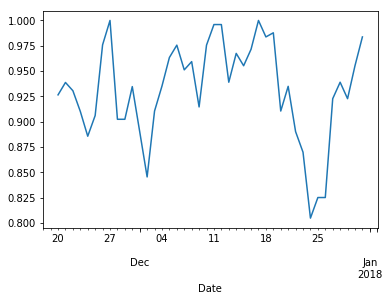

In [53]:
dfw['G&A beds_Occupancy rate'].plot()

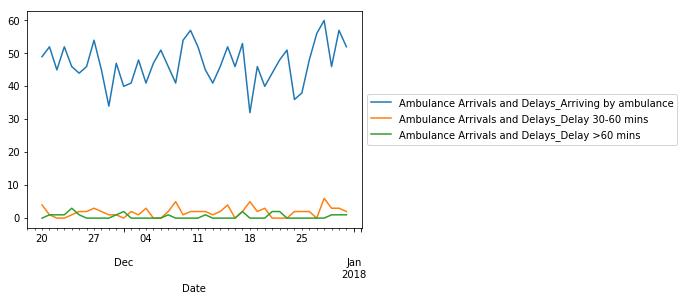

In [54]:
cols=[c for c in dfw.columns if 'Ambulance Arrivals' in c]
dfw[cols].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [55]:
cols

['Ambulance Arrivals and Delays_Arriving by ambulance',
 'Ambulance Arrivals and Delays_Delay 30-60 mins',
 'Ambulance Arrivals and Delays_Delay >60 mins']

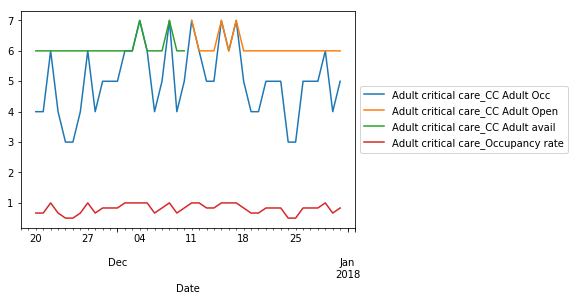

In [56]:
cols=[c for c in dfw.columns if 'Adult critical' in c]
dfw[cols].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [57]:
cols

['Adult critical care_CC Adult Occ',
 'Adult critical care_CC Adult Open',
 'Adult critical care_CC Adult avail',
 'Adult critical care_Occupancy rate']

In [58]:
dfw[cols].head()

ReportCategory,Adult critical care_CC Adult Occ,Adult critical care_CC Adult Open,Adult critical care_CC Adult avail,Adult critical care_Occupancy rate
Date,,,,
2017-11-20,4.0,NaN,6.0,0.666667
2017-11-21,4.0,NaN,6.0,0.666667
2017-11-22,6.0,NaN,6.0,1.000000
2017-11-23,4.0,NaN,6.0,0.666667
2017-11-24,3.0,NaN,6.0,0.500000


In [59]:
code='R1F'

startDate = '2017-12-25'
endDate = '2017-12-31'

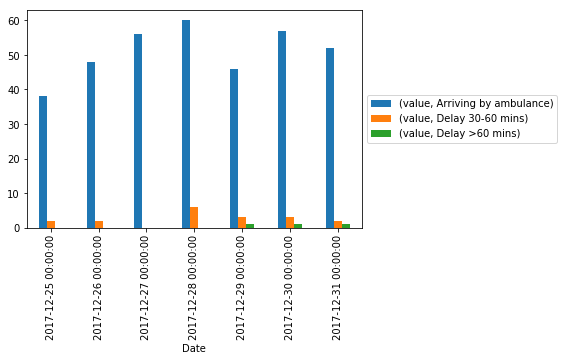

In [60]:
q5='''
SELECT Date, Name, Category, value FROM sitrep WHERE Report='Ambulance Arrivals and Delays'
AND date(Date) BETWEEN date('{fromdate}') AND date('{todate}')
AND Code = '{code}'
'''.format(fromdate='2017-12-25', todate='2017-12-31',code=code)
tmp = pd.read_sql_query(q5, conn, parse_dates=['Date'])
tmp_p = tmp[['Date','Category','value']].pivot_table(index='Date',columns='Category')
tmp_p.plot(kind='bar').legend(loc='center left', bbox_to_anchor=(1, 0.5));

Example report: https://onthewight.com/50-patients-stuck-outside-st-marys-in-ambulances-for-up-to-an-hour-in-december/

> Ambulances were forced to wait up to an hour at A&E 52 times on the Isle of Wight last month, with emergency patients stranded inside the vehicles waiting to be admitted.

> The NHS has released statistics concerning Isle Of Wight NHS Trust as part of a special series which highlights the winter pressures facing the health service.

 >The figures show that in December, 52 of the Trust’s patients had to spend between half an hour and an hour waiting in an ambulance at hospital, before they could be transferred to the emergency department.

>Some for more than an hour 13 were stuck in ambulances for more than 60 minutes.

> NHS England’s target time is up to 15 minutes.

> The waits, known as handover delays, can be due to ambulance queues or slow processing at hospitals, and can have the knock-on effect of delaying paramedics being despatched to future emergencies.

> In total 5.4% of all patients arriving by ambulances at hospital were delayed by between 30 and 60 minutes.

Let's have a go at trying to match those numbers...

In [61]:
q_month='''
SELECT Date, Name, Category, SUM(value) FROM sitrep WHERE Report='Ambulance Arrivals and Delays'
AND date(Date) BETWEEN date('{fromdate}') AND date('{todate}')
AND Code = '{code}'
GROUP BY Category
'''.format(fromdate='2017-12-01', todate='2017-12-31',code=code)
pd.read_sql_query(q_month, conn, parse_dates=['Date'])


,Date,Name,Category,SUM(value)
0,2017-12-31,Isle Of Wight NHS Trust,Arriving by ambulance,1455
1,2017-12-31,Isle Of Wight NHS Trust,Delay 30-60 mins,59
2,2017-12-31,Isle Of Wight NHS Trust,Delay >60 mins,13


I can match the *13 over an hour* but not the others?

In [62]:
q_pc='''
SELECT total.Name, Delayed, Total, 100.0*Delayed/Total AS pc FROM (SELECT  Name, SUM(value) AS Delayed FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND (Category = 'Delay >60 mins' OR Category='Delay 30-60 mins') 
AND Code = '{code}'
AND value NOT NULL GROUP BY Name) delayed JOIN (SELECT  Name, SUM(value) AS Total FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category = 'Arriving by ambulance' 
AND Code = '{code}'
AND value NOT NULL GROUP BY Name) total on total.Name = delayed.Name 
ORDER BY pc DESC
'''.format(fromdate='2017-12-01', todate='2017-12-31',code=code)
pd.read_sql_query(q_pc, conn)

,Name,Delayed,Total,pc
0,Isle Of Wight NHS Trust,72,1455,4.948454


### Simple Report Generation

We can generate simple text reports from the data.

For example, something of the form *Last week, of M ambulance arrivals overall, N patients at LOCATION Y waited over thirty minutes, of which Z waited over one hour.*

In [191]:
def query_ambulance_arrivals(conn, code, period = 'last week'):
    q_simple='''
    SELECT Date, Name, Category, SUM(value) as Total FROM sitrep WHERE Report='Ambulance Arrivals and Delays'
    {period}
    AND Code = '{code}'
    GROUP BY Category
    '''.format(period=getperiod_sql_clause(period), code=code)

    return pd.read_sql_query(q_simple, conn).set_index('Category').to_dict(orient='index')

In [193]:
locationQuery = 'Wight'

trust,code = lookupTrustCode(conn,locationQuery, 'sitrep')
query_ambulance_arrivals(conn, code,'last week')

{'Arriving by ambulance': {'Date': '2017-12-31 00:00:00',
  'Name': 'Isle Of Wight NHS Trust',
  'Total': 357},
 'Delay 30-60 mins': {'Date': '2017-12-31 00:00:00',
  'Name': 'Isle Of Wight NHS Trust',
  'Total': 18},
 'Delay >60 mins': {'Date': '2017-12-31 00:00:00',
  'Name': 'Isle Of Wight NHS Trust',
  'Total': 3}}

In [198]:
def _report_ambulance_arrivals(repdict):
    repdict['overall'] = p.number_to_words(resp['Arriving by ambulance']['Total'])
    repdict['over60'] = p.number_to_words(resp['Delay >60 mins']['Total'])
    repdict['over30'] = p.number_to_words(resp['Delay 30-60 mins']['Total'])

    txt = '''\
{nl_period}, of {overall} {location} ambulance arrivals overall, {over30} incurred a handover delay between thirty minutes and an hour \
and {over60} had a delay of over an hour.'''.format(**repdict)
    return txt

def report_ambulance_arrivals(conn, locationQuery, period='last week'):
    trust,code = lookupTrustCode(conn,locationQuery, 'sitrep')
    query_ambulance_arrivals(conn, code, period)
    repdict={}
    repdict['location'] = trust
    repdict['nl_period']=period.capitalize()
    return  _report_ambulance_arrivals(repdict)

In [199]:
txt = report_ambulance_arrivals(conn, locationQuery, 'last week')
print(txt)

Last week, of three hundred and fifty-seven Isle Of Wight NHS Trust ambulance arrivals overall, eighteen incurred a handover delay between thirty minutes and an hour and three had a delay of over an hour.


### More Example Reports

In [63]:
q_month='''
SELECT Date, Name, Category, value FROM sitrep WHERE Report='Ambulance Arrivals and Delays'
AND date(Date) BETWEEN date('{fromdate}') AND date('{todate}')
AND Code = '{code}' 
AND Category = 'Delay 30-60 mins'
ORDER BY Category,Date
'''.format(fromdate='2017-12-01', todate='2017-12-31',code=code)
pd.read_sql_query(q_month, conn, parse_dates=['Date'])

,Date,Name,Category,value
0,2017-12-01,Isle Of Wight NHS Trust,Delay 30-60 mins,0
1,2017-12-02,Isle Of Wight NHS Trust,Delay 30-60 mins,2
2,2017-12-03,Isle Of Wight NHS Trust,Delay 30-60 mins,1
3,2017-12-04,Isle Of Wight NHS Trust,Delay 30-60 mins,3
4,2017-12-05,Isle Of Wight NHS Trust,Delay 30-60 mins,0
5,2017-12-06,Isle Of Wight NHS Trust,Delay 30-60 mins,0
6,2017-12-07,Isle Of Wight NHS Trust,Delay 30-60 mins,2
7,2017-12-08,Isle Of Wight NHS Trust,Delay 30-60 mins,5
8,2017-12-09,Isle Of Wight NHS Trust,Delay 30-60 mins,1
9,2017-12-10,Isle Of Wight NHS Trust,Delay 30-60 mins,2


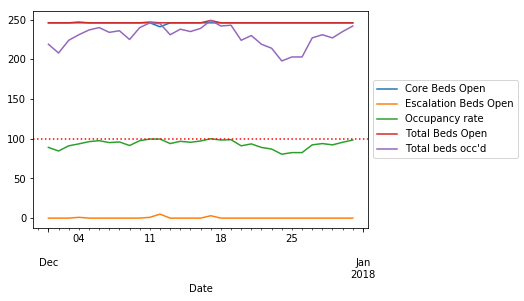

In [64]:
#Beds last month
fromdate,todate=ntpd.last_month(iso=True)

q_month_beds='''
SELECT Date, Name, Category, value FROM sitrep WHERE Report='G&A beds'
AND date(Date) BETWEEN date('{fromdate}') AND date('{todate}')
AND Code = '{code}'
'''.format(fromdate=fromdate, todate=todate,code=code)
tmp_b = pd.read_sql_query(q_month_beds, conn, parse_dates=['Date'])


tmp_b = tmp_b[['Date','Category','value']].pivot_table(index='Date',columns='Category')

#tmp_b[('value','Occupancy rate')] = 100*tmp_b[('value','Occupancy rate')]
tmp_b.columns = tmp_b.columns.get_level_values(1)
tmp_b['Occupancy rate'] = 100*tmp_b['Occupancy rate']


tmp_b.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=100, color='r', linestyle=':');

Days when G&A escalation beds were open:

In [65]:
q_esc_beds_open_on='''
SELECT Date FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category ='Escalation Beds Open' AND value > 0.0
AND Code = '{code}'
'''.format(fromdate='2017-12-01', todate='2017-12-31',code=code)

pd.read_sql_query(q_esc_beds_open_on, conn, parse_dates=['Date'])

,Date
0,2017-12-04
1,2017-12-11
2,2017-12-12
3,2017-12-17


In [66]:
q_peak_occ_beds = '''
SELECT Date, Category, value FROM sitrep WHERE Date IN (SELECT Date FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category = 'Occupancy rate'
AND Code = '{code}'
ORDER BY value DESC LIMIT 5 ) 
AND Report = 'G&A beds' AND Code = '{code}'
'''.format(fromdate='2017-12-01', todate='2017-12-31',code=code)

pd.read_sql_query(q_peak_occ_beds, conn, parse_dates=['Date'])

,Date,Category,value
0,2017-12-02,Core Beds Open,246.000000
1,2017-12-02,Escalation Beds Open,0.000000
2,2017-12-02,Total Beds Open,246.000000
3,2017-12-02,Total beds occ'd,208.000000
4,2017-12-02,Occupancy rate,0.845528
5,2017-12-03,Core Beds Open,246.000000
6,2017-12-03,Escalation Beds Open,0.000000
7,2017-12-03,Total Beds Open,246.000000
8,2017-12-03,Total beds occ'd,224.000000
9,2017-12-03,Occupancy rate,0.910569


In [67]:
q_fully_occupied = '''
SELECT Date, Category, value FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category = 'Occupancy rate'
AND Code = '{code}'
AND value = 1
AND Report = 'G&A beds' 
AND Code = '{code}'
'''.format(fromdate='2017-12-01', todate='2017-12-31',code=code)

pd.read_sql_query(q_fully_occupied, conn, parse_dates=['Date'])

,Date,Category,value
0,2017-12-17,Occupancy rate,1


In [68]:
q_month_esc_beds='''
SELECT Date, Name, Category, value FROM sitrep 
WHERE Report='G&A beds'
AND Code = '{code}'
AND Date IN 
    (SELECT Date FROM sitrep 
        WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
        AND Category ='Escalation Beds Open' AND value > 0.0
        AND Code = '{code}'
    ) 
'''.format(fromdate='2017-12-01', todate='2017-12-31',code=code)

pd.read_sql_query(q_month_esc_beds, conn, parse_dates=['Date'])

,Date,Name,Category,value
0,2017-12-04,Isle Of Wight NHS Trust,Core Beds Open,246.000000
1,2017-12-04,Isle Of Wight NHS Trust,Escalation Beds Open,1.000000
2,2017-12-04,Isle Of Wight NHS Trust,Total Beds Open,247.000000
3,2017-12-04,Isle Of Wight NHS Trust,Total beds occ'd,231.000000
4,2017-12-04,Isle Of Wight NHS Trust,Occupancy rate,0.935223
5,2017-12-11,Isle Of Wight NHS Trust,Core Beds Open,246.000000
6,2017-12-11,Isle Of Wight NHS Trust,Escalation Beds Open,1.000000
7,2017-12-11,Isle Of Wight NHS Trust,Total Beds Open,247.000000
8,2017-12-11,Isle Of Wight NHS Trust,Total beds occ'd,246.000000
9,2017-12-11,Isle Of Wight NHS Trust,Occupancy rate,0.995951


In [69]:
q_peak_occ_beds_acc = '''
SELECT Date, Category, value FROM sitrep WHERE Date IN (SELECT Date FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category = 'Occupancy rate'
AND Code = '{code}'
ORDER BY value DESC LIMIT 5 ) 
AND Report = 'Adult critical care' AND Code = '{code}'
'''.format(fromdate='2017-12-01', todate='2017-12-31',code=code)

pd.read_sql_query(q_peak_occ_beds_acc, conn, parse_dates=['Date'])

,Date,Category,value
0,2017-12-02,CC Adult avail,6
1,2017-12-02,CC Adult Occ,6
2,2017-12-02,Occupancy rate,1
3,2017-12-03,CC Adult avail,6
4,2017-12-03,CC Adult Occ,6
5,2017-12-03,Occupancy rate,1
6,2017-12-04,CC Adult avail,7
7,2017-12-04,CC Adult Occ,7
8,2017-12-04,Occupancy rate,1
9,2017-12-05,CC Adult avail,6


# NHS 111

In [70]:
xl=DailySR_read('sitrep/111-for-winter-daily-sitrep-up-to-20171231-unlinked.xlsx')
reports = [n for n in  xl.sheet_names if n !='Macro1']
reports

['Answered in 60',
 'Abandoned',
 'Triage',
 'Clinical Advisor',
 'Clinical Input',
 'Call Back',
 'Dispositions']

In [50]:
def disposition_report(conn, code, nl_period=None):
    q='''SELECT DISTINCT Report, Category, Code, SUM(value) as Total FROM nhs111 
    WHERE Report='Dispositions'
    AND Code= '{code}'
    {period}
    GROUP BY Category;
    
    '''.format(code=code, period=getperiod_sql_clause(nl_period))
    return pd.read_sql_query(q, conn)
                      
code= '111AA6'
disposition_report(conn, code, 'last month' )

,Report,Category,Code,Total
0,Dispositions,Ambulance dispatches,111AA6,1058.0
1,Dispositions,Given health information,111AA6,90.0
2,Dispositions,Not recommended to attend other service,111AA6,1031.0
3,Dispositions,Recommended home Care,111AA6,288.0
4,Dispositions,Recommended non clinical,111AA6,653.0
5,Dispositions,Recommended to attend A&E,111AA6,601.0
6,Dispositions,Recommended to attend other service,111AA6,250.0
7,Dispositions,Recommended to attend primary and community care,111AA6,4412.0
8,Dispositions,Recommended to contact primary care,111AA6,3049.0
9,Dispositions,Recommended to dental,111AA6,460.0


## Generate a written report

*Perhaps also offer ability to compare with previous same period?*

In [241]:
def bulleted_list_builder(reps, header=''):
    for rep in reps:
        header+='\n\t- {}'.format(rep)
    return header

def report_disposition(conn,code,nl_period=None, intify=None):
    def _reporter(row):
        txt='''{Category}: {Total}'''.format(**row)
        return txt
    df = disposition_report(conn, code, nl_period )
    if intify:
        df[intify]=df[intify].astype(int)

    return df.apply(_reporter,axis=1)

period = 'last month'
locationQuery = 'Wight'

trust,code = lookupTrustCode(conn,locationQuery, 'nhs111')


print( bulleted_list_builder( report_disposition(conn,code,period, intify='Total' ),
                             header = 'NHS111 dispositions for {} {} {}:'.format(trust, period,period_text(period) )) )

NHS111 dispositions for Isle Of Wight NHS 111 last month (Friday 01 December 2017 to Sunday 31 December 2017):
	- Ambulance dispatches: 1058
	- Given health information: 90
	- Not recommended to attend other service: 1031
	- Recommended home Care: 288
	- Recommended non clinical: 653
	- Recommended to attend A&E: 601
	- Recommended to attend other service: 250
	- Recommended to attend primary and community care: 4412
	- Recommended to contact primary care: 3049
	- Recommended to dental: 460
	- Recommended to pharmacy: 16
	- Recommended to speak to primary care: 887
